<a href="https://colab.research.google.com/github/ashmcmn/brain_MRI_estimations/blob/master/qBOLD_Model_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Intro

The qBOLD model/method allows for the evaluation of bio-physiological parameters such as oxygen extraction fraction (OEF), deoxygenated blood volume (DBV) and reversible transverse relaxation rate ($R'_2$). This notebook details various implementations of the method in an attempt to maximise the accuracy of these predictions. If you want to read in detail about the theory of qBOLD, I recommend reading the paper "Quantitative BOLD: Mapping of human cerebral deoxygenated blood volume and oxygen extraction fraction:  Default state" by He, X. & Yablonskiy, D. A. from 2007.

In [ ]:
import nibabel as nib
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from mlxtend.plotting import plot_decision_regions
from sklearn.preprocessing import MinMaxScaler, StandardScaler

!gdown --id '1zTZoh71HXmT3EBPkm0ku5ySEcjX3l98l'
img = nib.load('slice4_ASE.nii.gz')

In [2]:
hct = 0.34; # hct ratio in small vessels
dMagSus = 0.264*10**-6; # ppm, sus difference between fully oxy & deoxy rbc's
pGyro = 2.675*10**4; # rads/(secs.Gauss) gyromagnetic ratio
fStr = 3*10**4; # Gauss, Field strength
oCap = 1.34; # mlO2/gHb

# The Data
Here's a quick look into the data provided. Typically, when fetching data from a .nii file it is of shape (a, b, c, d) where a and b define the image resolution, c is the number of slices and d is the number time intervals the data was recorded at (post-excitation). The data sample used here is a single slice of resolution 96x96, recorded at 11 different time intervals. These time intervals are the delays from initial excitation at which the signals are measured. The 'tau' values for this fMRI scan ranged from -16ms to 64ms at a step of 8ms, such that the first three values are -16ms, -8ms and 0ms. Rendering the images in chronological order below visualizes the measurements of signals recorded during the ASE pulse sequence. You can see the signal strength decay over time.

In [ ]:
data = img.get_fdata().reshape((96, 96, 11))
taus = range(-16,65,8)

fig, axes = plt.subplots(3, 4, figsize=(18, 14))
axes = axes.ravel()
[a.set_axis_off() for a in axes.ravel()]

for t in range(data.shape[2]):
  im = axes[t].imshow(data[:,:,t], vmax=255)
  plt.colorbar(im, ax=axes[t])
  axes[t].set_title('Signal measurements\noffset {}ms from excitation'.format(taus[t]))

If we a single pixel of the image from an area with varying signal strength over time we can visualize the decay. The general idea is to create a system that, when given data like this, can predict the aforementioned parameters, accurately.

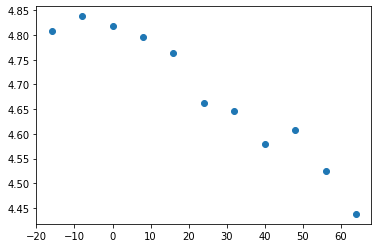

In [ ]:
excerpt = np.log(data[50,50,:])
plt.scatter(taus, excerpt)

# Linear Evaluation of Parameters Using Linear Regression
Taking a look at the visualisation of data above and compare it the brilliant figure below from the 2017 paper by A.J. Stone and N.P. Blockley. We can see captured signals can be characterized by the qBOLD signal. If we use linear regression on the data, knowing that the signal decay is equivalent to $R'_2$, we can take the gradient of the solution to be $R'_2$. DBV can then be calculated using the intercept of the solution, that just leaves OEF. OEF can be calculated from the deoxyhaemoglobin concentration (dHb) and the haemoglobin concentration (Hb). dHb can be calculated from $R'_2$ and DBV assuming knowledge of other constants, Hb can be inferred given the expected proportion of hematocrit and finally then OEF can be calculated using these values. In practice OEF is simplified into a single equation.

![](https://drive.google.com/uc?export=view&id=1mqvTHTVoS-B-jkNDJRyzv3t_lTwj-zw0)

In [ ]:
# @title Manual Linear Regression (Double-Click to Open)
class QBOLD_LR():
  def __init__(self, hct, dMagSus, pGyro, fStr, oCap, cTime, tConf):
    self.hct = hct
    self.dMagSus = dMagSus
    self.pGyro = pGyro
    self.fStr = fStr
    self.oCap = oCap
    self.cTime = cTime
    [tStart, tEnd, tStep] = tConf
    self.taus = np.array(range(tStart, tEnd+1, tStep))*10**-3

  def _fit_single(self, xdata):
    x = np.vstack([self.taus, np.ones_like(taus)])
    idx = np.where(self.taus > self.cTime)[0]
    x = np.take(x, idx, axis=1)
    xdata = np.take(xdata, idx)
    return np.dot(np.linalg.pinv(x).T, xdata.reshape(xdata.shape[0],1)).flatten()

  def _fit_single_sk(self, xdata):
    idx = np.where(self.taus > self.cTime)[0]
    x = np.take(self.taus, idx)
    w = np.sqrt(np.diag((1. / x).T))
    x = np.vstack([x, np.ones(len(x))]).T
    xw = np.dot(w, x) 
    y = np.take(xdata, idx)
    yw = np.dot(y.T, w)

    m, c = np.linalg.lstsq(xw, yw.T, rcond=None)[0]
    return [m, c]

  def fit(self, xdata, method='manual'):
    self.data = xdata
    dim = self.data.shape
    self.lr = np.zeros((*dim[:2],2))

    for x in range(dim[0]):
      for y in range(dim[1]):
        if method == 'manual':
          self.lr[x,y,:] = self._fit_single(self.data[x,y])
        elif method == 'sk':
          self.lr[x,y,:] = self._fit_single_sk(self.data[x,y])

  def visualise_qbold(self, x, y):
    excerpt = self.data[x, y, :]
    lr = self.lr[x, y, :]

    line_x = np.linspace(self.taus[0], self.taus[-1], 100).reshape((-1,1)) 

    fig, ax = plt.subplots()

    ax.axvline(self.cTime, color='black', linestyle='--', label='Tc')
    ax.plot(line_x, lr[0]*line_x + lr[1], color='r', label='R2P')
    ax.scatter(self.taus, excerpt, label='Original Data')
    ax.set_xlabel('Displacement from SE, tau /ms')
    ax.set_ylabel('ln(signal)')
    legend = ax.legend(loc='upper right', shadow=True, fontsize='x-large')
    plt.show()

  def _calculate_parameters(self, x, y):
    excerpt = self.data[x, y, :]
    lr = self.lr[x, y, :]

    r2p = -self.lr[x, y, 0]
    dbv = self.lr[x, y, 1] - self.data[x, y, np.where(self.taus == 0)].flatten()[0]
    return [r2p, dbv]

In [ ]:
model = QBOLD_LR(hct, dMagSus, pGyro, fStr, oCap, 0.017, [-16,64,8])
model.fit(np.log(data))

res = np.zeros((*data.shape[:2], 2))
for x in range(res.shape[0]):
  for y in range(res.shape[1]):
    res[x][y] = model._calculate_parameters(x, y)

df = pd.DataFrame(res.reshape(-1, 2), columns=['R2P', 'DBV'])
df['DBV'] = df['DBV'] * 100
df.dropna(inplace=True)
df.clip(0, inplace=True)
print('Mean R2P of {:.2f}Hz, Mean DBV of {:.2f}%'.format(*df.mean()))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log
  


Mean R2P of 5.20Hz, Mean DBV of 8.25%


In [ ]:
model = QBOLD_LR(hct, dMagSus, pGyro, fStr, oCap, 0.017, [-16,64,8])
model.fit(np.log(data), method='sk')

res = np.zeros((*data.shape[:2], 2))
for x in range(res.shape[0]):
  for y in range(res.shape[1]):
    res[x][y] = model._calculate_parameters(x, y)

df = pd.DataFrame(res.reshape(-1, 2), columns=['R2P', 'DBV'])
df['DBV'] = df['DBV'] * 100
df.dropna(inplace=True)
df.clip(0, inplace=True)
print('Mean R2P of {:.2f}Hz, Mean DBV of {:.2f}%'.format(*df.mean()))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log
  


Mean R2P of 5.10Hz, Mean DBV of 7.73%


# Non-Linear Evaluation of Parameters Using Neural Networks
As you've probably noticed, the methods used above extrapolate the parameters from a linear regime. The aim in using neural networks is to train a model that is capable of accurately predicting parameters making use of all the data by using non-linear activation functions. The first problem encountered here is the lack of training data. Not only is the data provided limited but it is also untagged, hence supervised learning would be ruled out. To overcome this problem, I will simulate signals by rearranging the equation for the quadratic exponential profile of $R_2'$ decay. The equation is defined differently in the two regimes separated by the characteristic time, these are equations 7 a & b in the aforementioned 2017 Stone & Blockley paper.


In [120]:
#@title Class for predicting R2P and deriving OEF and DBV (double-click)
class QBOLD_NN():
  def __init__(self, hct, dMagSus, pGyro, fStr, tConf, oefR, dbvR):
    self.hct = hct
    self.dMagSus = dMagSus
    self.pGyro = pGyro
    self.fStr = fStr
    [tStart, tEnd, tStep] = tConf
    self.taus = np.array(range(tStart, tEnd+1, tStep))*10**-3
    self.oefR = oefR
    self.dbvR = dbvR

  def generate(self, n):
    n = np.sqrt(n)
    c = 3/(4 * np.pi*self.pGyro*self.fStr*self.dMagSus)

    if not n.is_integer():
      print('Please give a perfect square number')
      return

    n = int(n)

    tc = 0.016

    oef = np.linspace(0.20, 0.70, n)
    dbv = np.linspace(0.003, 0.15, n)
    data = np.zeros((n**2, 15))

    i = 0
    for x in oef:
      for y in dbv:
        r2p = (x * self.hct * y)/c
        s0 = 1/np.exp(-11.5*0.074)*np.exp(-0.3*(r2p*-0.016)**2/y)
        st = []
        for t in self.taus:
          if t < tc:
            st.append(s0*np.exp(-11.5*0.074)*np.exp(-0.3*(r2p*t)**2/y))
          else:
            st.append(s0*np.exp(-11.5*0.074)*np.exp(y-r2p*t))
        data[i] = [x, y, r2p, s0]+st
        i += 1

    self.data = pd.DataFrame(data, columns=np.hstack((['OEF', 'DBV', 'R2P', 'S0'],self.taus)))

  def _split_data(self, split, ynames):
    data = self.data.sample(frac=1)

    x = data.to_numpy()[:,4:]
    y = data[ynames].to_numpy()
    idx = int(split*data.shape[0])

    self.trainx = x[:idx,:]
    self.trainy = y[:idx,:]
    self.testx = x[idx:,:]
    self.testy = y[idx:,:]

  def create_model(self, ynames=['R2P'], split=0.8, activation='relu', o='adam', lr=0.01, lf='mse', snr=100, n=10):
    self.model_config = {}
    self.model_config['ynames'] = ynames
    self.model_config['split'] = split
    self.model_config['activation'] = activation
    self.model_config['optimizer'] = o
    self.model_config['lr'] = lr
    self.model_config['lf'] = lf
    self.model_config['snr'] = snr
    self.model_config['n'] = n

    self._split_data(split, ynames)
 
    self.model = tf.keras.models.Sequential([
      tf.keras.layers.GaussianNoise(1/(np.sqrt(11)*snr)),
      tf.keras.layers.Dense(n, activation=activation),
      tf.keras.layers.Dense(len(ynames))
    ])

    if o == 'adam':
      optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
    elif o == 'sgd':
      optimizer = tf.keras.optimizers.SGD(learning_rate=lr)
    else:
      print('Optimizer not recognised.')
      return

    if lf == 'mse':
      loss = tf.keras.losses.MeanSquaredError()
    elif lf == 'mae':
      loss = tf.keras.losses.MeanAbsoluteError()
    else:
      print('Loss function not recognised.')
      return

    self.model.compile(optimizer=optimizer,
              loss=loss)
    
  def train_model(self, log_transform=False, epochs=100, patience=20, batch_size=1, verbose=0):
    self.model_config['log_transform'] = log_transform
    self.model_config['epochs'] = epochs
    self.model_config['patience'] = patience
    self.model_config['batch_size'] = batch_size

    es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=verbose, patience=patience)
    mc = tf.keras.callbacks.ModelCheckpoint('best_model.h5', monitor='val_loss', mode='min', verbose=verbose, save_best_only=True)

    trainx = self.trainx
    trainy = self.trainy
    testx = self.testx
    testy = self.testy

    if log_transform:
      trainx = np.log(trainx)
      testx = np.log(testx)

    history = self.model.fit(trainx, trainy, epochs=epochs, validation_data=(testx, testy), batch_size=batch_size, callbacks=[es, mc], verbose=verbose)

    self.model = tf.keras.models.load_model('best_model.h5')

    if verbose == 1:
      plt.plot(history.history['loss'], label='loss')
      plt.plot(history.history['val_loss'], label='val_loss')
      plt.xlabel('Epoch')
      plt.ylabel('Error [Hz]')
      plt.legend()
      plt.grid(True)
      plt.show()

    return history

  def predict_model(self, data):
    if self.model_config['log_transform']:
      data = np.log(data)

    predictions = self.model.predict(data)

    ynames = self.model_config['ynames']
    out = np.zeros((data.shape[0],3))

    try:
      out[:,0] = predictions[:,ynames.index('R2P')]
    except ValueError:
      print('R2P prediction is required')

    try:
      out[:,1] = predictions[:,ynames.index('DBV')]
    except ValueError:
      out[:,1] = 1 - data[:,np.where(self.taus==0)[0][0]]

    try:
      out[:,2] = predictions[:,ynames.index('OEF')]
    except ValueError:
      c = 3/(4 * np.pi*self.pGyro*self.fStr*self.dMagSus)
      out[:,2] = (c*out[:,0])/(self.hct*out[:,1])
      
    return pd.DataFrame(out, columns=['R2P(P)', 'DBV(P)', 'OEF(P)'])

Epoch 1/1000
2000/2000 [==============================] - 3s 1ms/step - loss: 25.6700 - val_loss: 0.6089

Epoch 00001: val_loss improved from inf to 0.60895, saving model to best_model.h5
Epoch 2/1000
2000/2000 [==============================] - 3s 1ms/step - loss: 0.5415 - val_loss: 0.4235

Epoch 00002: val_loss improved from 0.60895 to 0.42354, saving model to best_model.h5
Epoch 3/1000
2000/2000 [==============================] - 3s 1ms/step - loss: 0.2823 - val_loss: 0.0368

Epoch 00003: val_loss improved from 0.42354 to 0.03675, saving model to best_model.h5
Epoch 4/1000
2000/2000 [==============================] - 3s 1ms/step - loss: 0.0238 - val_loss: 0.0148

Epoch 00004: val_loss improved from 0.03675 to 0.01480, saving model to best_model.h5
Epoch 5/1000
2000/2000 [==============================] - 3s 1ms/step - loss: 0.0133 - val_loss: 0.0118

Epoch 00005: val_loss improved from 0.01480 to 0.01182, saving model to best_model.h5
Epoch 6/1000
2000/2000 [========================

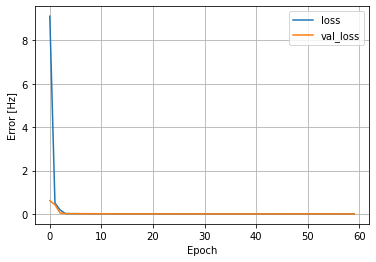

In [158]:
qboldnn = QBOLD_NN(hct, dMagSus, pGyro, fStr, [-16,64,8], [0.20, 0.70], [0.003, 0.15])
qboldnn.generate(10000)
qboldnn.create_model(ynames=['R2P', 'DBV'], split=0.8, activation='relu', o='adam', lr=1e-3, lf='mse', snr=100, n=20)
qboldnn.train_model(log_transform=True, epochs=1000, patience=20, batch_size=4, verbose=1)

In [159]:
excerpt = qboldnn.data.sample(frac=1).iloc[:10]
x = excerpt.to_numpy()[:,4:]
excerpt.reset_index(inplace=True)
predictions = qboldnn.predict_model(x)
excerpt = pd.concat([excerpt, predictions], axis=1)
excerpt[['OEF', 'DBV', 'R2P', 'OEF(P)', 'DBV(P)', 'R2P(P)']].style.format({
    'OEF': '{:.0%}'.format,
    'DBV': '{:.0%}'.format,
    'OEF(P)': '{:.0%}'.format,
    'DBV(P)': '{:.0%}'.format,
})

,OEF,DBV,R2P,OEF(P),DBV(P),R2P(P)
0,29%,14%,12.514672,30%,14%,12.501037
1,22%,12%,7.713364,24%,10%,7.664855
2,21%,14%,8.545505,24%,12%,8.480083
3,37%,14%,15.609427,36%,14%,15.626276
4,60%,7%,11.813326,60%,7%,11.823581
5,55%,10%,16.469118,53%,10%,16.489170
6,29%,2%,1.827328,31%,2%,1.834797
7,50%,12%,18.710166,48%,13%,18.738428
8,29%,7%,5.737332,30%,6%,5.737080
9,70%,10%,21.645828,77%,9%,21.618980


In [160]:
excerpt = qboldnn.data
x = excerpt.to_numpy()[:,4:]
y = excerpt.to_numpy()[:,2]
predictions = qboldnn.predict_model(x)
excerpt = pd.concat([excerpt, predictions], axis=1)
r2p_error = np.abs(np.diff(excerpt[['R2P', 'R2P(P)']].to_numpy())).mean()
dbv_error = np.abs(np.diff(excerpt[['DBV', 'DBV(P)']].to_numpy())).mean()
oef_error = np.abs(np.diff(excerpt[['OEF', 'OEF(P)']].to_numpy())).mean()
print(f'Total MAE:{r2p_error+dbv_error+oef_error:.4f}, R2P:{r2p_error:.4f}, DBV:{dbv_error:.4f}, OEF:{oef_error:.4f}')

Total MAE:0.0424, R2P:0.0155, DBV:0.0035, OEF:0.0234


In [161]:
r2p_error+dbv_error+oef_error

0.0423749397347072

           OEF       DBV        R2P    OEF(P)    DBV(P)     R2P(P)      Loss
2269  0.311111  0.105455   9.899137  0.316709  0.103590   9.899135  0.000002
1841  0.290909  0.063879   5.606999  0.303472  0.061234   5.607005  0.000006
2052  0.301010  0.080212   7.285134  0.310055  0.077872   7.285128  0.000006
8663  0.634343  0.096545  18.478758  0.650523  0.094144  18.478765  0.000008
1946  0.295960  0.071303   6.367323  0.306752  0.068794   6.367313  0.000010
...        ...       ...        ...       ...       ...        ...       ...
198   0.205051  0.148515   9.188574  0.237498  0.127119   9.109349  0.079224
97    0.200000  0.147030   8.872650  0.234017  0.124429   8.785878  0.086772
199   0.205051  0.150000   9.280441  0.238380  0.127790   9.191454  0.088987
98    0.200000  0.148515   8.962254  0.234911  0.125079   8.865545  0.096709
99    0.200000  0.150000   9.051858  0.235796  0.125730   8.945211  0.106647

[10000 rows x 7 columns]


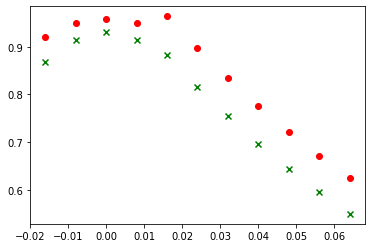

In [162]:
#@title What does data look like for cases with large loss? (Double-click to open)
excerpt = qboldnn.data
x = excerpt.to_numpy()[:,4:]
y = excerpt.to_numpy()[:,2]
predictions = qboldnn.predict_model(x)
excerpt = pd.concat([excerpt, predictions], axis=1)
excerpt[['OEF', 'DBV', 'R2P', 'OEF(P)', 'DBV(P)', 'R2P(P)']]
excerpt['Loss'] = np.abs(y-predictions['R2P(P)'])
print(excerpt.sort_values(by=['Loss'])[['OEF', 'DBV', 'R2P', 'OEF(P)', 'DBV(P)', 'R2P(P)', 'Loss']])
best = excerpt.sort_values(by=['Loss']).to_numpy()[0]
worst = excerpt.sort_values(by=['Loss'], ascending=False).to_numpy()[0]

plt.scatter(qboldnn.taus, best[4:15], marker='x', c='green')
plt.scatter(qboldnn.taus, worst[4:15], c='red')
plt.show()